# Aspect Based Sentiment Analysis (ABSA)
2024 CITS4012 Project

Franco.meng2@gmail.com

May, 2024




# 1.Dataset Processing

## 1.1 Initial Preparation

Downloading Packages - Reading in data files - downloading pre trained word embeddings



*   glove-twitter-25
*   glove-twitter-50
*   word2vec-google-news-300



In [1]:
from google.colab import files
import json
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
import os
import re
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
import numpy as np
from torch.utils.data import TensorDataset
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import accuracy_score
import torch.nn.functional as F
from sklearn.metrics import classification_report

# uploaded = files.upload()
# filename = next(iter(uploaded))
# with open(filename) as file:
#     data = json.load(file)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
with open("/content/train.json") as file:
    train_data = json.load(file)["data"]

with open("/content/val.json") as file:
    val_data = json.load(file)["data"]

with open("/content/test.json") as file:
    test_data = json.load(file)["data"]

Reading in training / validation / testing files

In [4]:
t_sentence = [a for a,_,_ in train_data]
t_aspect = [b for _,b,_ in train_data]
t_polarity = [c for _,_,c in train_data]

In [5]:
v_sentence = [a for a,_,_ in val_data]
v_aspect = [b for _,b,_ in val_data]
v_polarity = [c for _,_,c in val_data]

In [6]:
test_sentence = [a for a,_,_ in test_data]
test_aspect = [b for _,b,_ in test_data]
test_polarity = [c for _,_,c in test_data]

In [7]:
import gensim.downloader as api
word_emb_model1 = api.load("glove-twitter-25")
word_emb_model2 = api.load("glove-twitter-50")
word_emb_model3 = api.load("word2vec-google-news-300")

[==================================================] 100.0% 104.8/104.8MB downloaded
[==================================================] 100.0% 199.5/199.5MB downloaded
[==================================================] 100.0% 1662.8/1662.8MB downloaded


## 1.2 Word processing

*  case folding
*  contraction processing
*  remove punctruation
*  tokenization

In [8]:
contraction_dict = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have",
                    "couldn't": "could not", "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not",
                    "hasn't": "has not", "haven't": "have not", "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did",
                    "how'd'y": "how do you", "how'll": "how will", "how's": "how is",  "I'd": "I would", "I'd've": "I would have",
                    "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would", "i'd've": "i would have",
                    "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                    "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us",
                    "ma'am": "madam", "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have",
                    "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have",
                    "o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not",
                    "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have",
                    "she's": "she is", "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have",
                    "so's": "so as", "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                    "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                    "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not",
                    "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have",
                    "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",  "what's": "what is", "what've": "what have",
                    "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will",
                    "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have",
                    "won't": "will not", "won't've": "will not have", "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have",
                    "y'all": "you all", "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                    "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have"}

In [9]:
def pre_process(sent_list):
    output = []
    for sent in sent_list:
        sent = sent.lower() #case-folding
        for word, new_word in contraction_dict.items():
            sent = sent.replace(word, new_word) #dealing with contractions
        sent = re.sub(r'[^\w\s]','',sent) #removing punctuation
        output.append(word_tokenize(sent)) #tokenization
    return output

In [10]:
t_sentence_1 = pre_process(t_sentence)
v_sentence_1 = pre_process(v_sentence)
test_sentence_1 = pre_process(test_sentence)

## 1.3 Creating word2idx dictionary for word embeddings.



Using all the words in the training + validations, along with words for asepcts.

As some aspects words like ' miscellaneous ' may never occure in the sentences of the review, I feel it is a bit arbitary to use OOV for these aspect key words.
Therefore in the dictionary 2-9, will be the aspects words.

In [11]:
word2idx = {'<PAD>': 0, '<OOV>': 1, 'ambience' : 2, 'food': 3, 'menu' :4, 'miscellaneous':5, 'place':6, 'price':7, 'service' : 8, 'staff':9}
for sentence in t_sentence_1 + v_sentence_1 :
    for word in sentence:
        if word not in word2idx:
            word2idx[word] = len(word2idx)

*  Concatanating glove-twitter-25 and glove-twitter-50 for my first word embedding option

* Note : Please use the second option for all the models, as the word2vec-google-news-300 shows strong improvement. Here just illustrate what have been experimented.

In [12]:
emb_dim = word_emb_model1.vector_size + word_emb_model2.vector_size

In [13]:
emb_table = []
for i, word in enumerate(word2idx):
    if word in word_emb_model1:
        emb_table.append(np.concatenate((word_emb_model1[word],word_emb_model2[word]),0)) #FM 0 HERE means concatenate two arrays on dimention of 0 ,
    else:
        emb_table.append([0]*emb_dim)
emb_table = np.array(emb_table)

*  Using word2vec-google-news-300, 300 dimention word representation for my second word embedding options.

In [12]:
emb_dim = word_emb_model3.vector_size
emb_dim
emb_table = []
for i, word in enumerate(word2idx):
    if word in word_emb_model3:
        emb_table.append(word_emb_model3[word])
    else:
        emb_table.append([0]*emb_dim)
emb_table = np.array(emb_table)

*  Creating a idx2word dictionary for easier convering number back to words.

In [13]:
idx2word =  {i: t for t, i in word2idx.items()}

In [14]:
{k: idx2word[k] for k in sorted(idx2word.keys())[:10]}

{0: '<PAD>',
 1: '<OOV>',
 2: 'ambience',
 3: 'food',
 4: 'menu',
 5: 'miscellaneous',
 6: 'place',
 7: 'price',
 8: 'service',
 9: 'staff'}

## 1.3 sentence encoding.

Here I encode the sentence, converting all the words in the sentence, by using the word2idx dictionary just created above, in to interger format.

e.g. "I like pasta" --> "3,5,6"

In [15]:
def encode_sentences(sentences):
    res = []
    for sent in sentences:
        # For any word that is not in our word vocab, use [OOV] for representating it
        temp = [word2idx[word.lower()] if word.lower() in word2idx else word2idx['<OOV>'] for word in sent]
        res.append(temp)
    return res

I've decided to combine training + validation into a bigger training set to increase the volcabulary for better model training.

In [16]:
t_combine_sentence_encoded = encode_sentences(t_sentence_1+v_sentence_1 )
test_encoded = encode_sentences(test_sentence_1)

## 1.4 data exploratory analysis , and sentence padding.

In order to use batch processing, usually the sentence will be padded to the same length.




1.   Data Exploration : investigating distribution of sentence length, aspects and polarity.
* Usually the padded length = max (sentence length), however I do not wish to pad all the sentence to the max length if there are outliers, where only 1 or 2 sentences are super long in my training set.
2.   Creating a function to pad sentences.




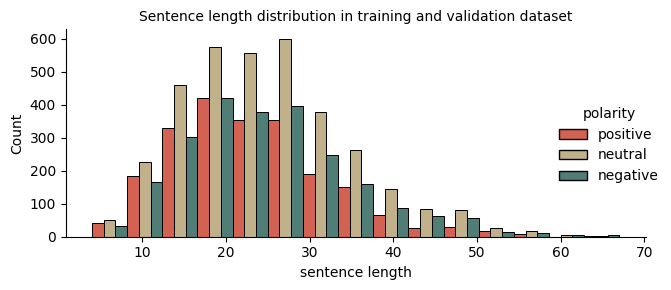

In [17]:
lenlist = []
for i in t_combine_sentence_encoded:
    lenlist.append(len(i))
label_list = t_polarity + v_polarity
my_palette = sns.color_palette(["#C52E19", "#AC9765", "#175149"])
df_plot = pd.DataFrame(list(zip(lenlist, label_list)),
               columns =['sentence length', 'polarity'])
sns.displot(df_plot,x="sentence length", bins = 15,hue="polarity", multiple="dodge",palette = my_palette,height=3, aspect=15/8)
plt.title("Sentence length distribution in training and validation dataset",fontsize = 10)
plt.tight_layout()
plt.savefig("Fig_sentence_length.png")

In [ ]:
from collections import Counter
Counter(label_list)
len(label_list)

In [220]:
files.download('Fig_sentence_length.png')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

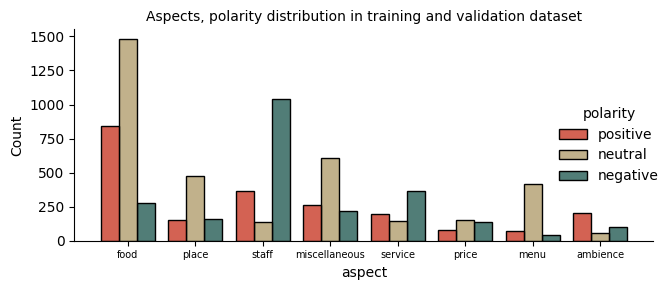

In [18]:
df_plot_aspect = pd.DataFrame(list(zip(t_aspect + v_aspect, t_polarity + v_polarity)),
               columns =['aspect', 'polarity'])
g1 = sns.displot(df_plot_aspect,x="aspect", hue="polarity", multiple="dodge", palette = my_palette,height=3, aspect=15/8, shrink=.8)
plt.xticks(rotation=0, size = 7)
plt.title("Aspects, polarity distribution in training and validation dataset",fontsize = 10)
plt.tight_layout()
plt.savefig("Fig_aspect.png")

In [222]:
files.download('Fig_aspect.png')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

As expected, very few instances with sentence length over 60. I don't believe it is a good idea to PAD all sentence to max length of 67.

In [19]:
max_length = len(max(t_combine_sentence_encoded, key=len))
print(max_length)

67


In [19]:
max_length = 45 #decision of padded length after different experiments

In [22]:
def pad_sequence(seq_list, max_length, index_dict):
    res = []
    for seq in seq_list:
        temp = seq[:]
        if len(seq)>max_length:
            res.append(temp[:max_length])
        else:
            temp += [index_dict['<PAD>']] * (max_length - len(seq))
            res.append(temp)
    return np.array(res)

In [21]:
t_combine_sentence_encoded_pad = pad_sequence(t_combine_sentence_encoded, max_length, word2idx)
test_encoded_paded = pad_sequence(test_encoded, max_length, word2idx)

Creating a polarity map, converting aspect to interger representations.

In [23]:
label_map = {"positive": 0, "negative": 1, "neutral": 2}
polarity = ["positive", "negative", "neutral"]
label_combine =np.array([ label_map[i] for i in t_polarity + v_polarity]) #training label
test_label = np.array([ label_map[i] for i in test_polarity]) #testing label

In [24]:
aspect_combine = np.array([ [word2idx[i]] for i in t_aspect + v_aspect])

In [25]:
test_aspect = np.array([ [word2idx[i]] for i in test_aspect])

In [26]:
len(t_combine_sentence_encoded_pad) #checking how many instances for training

7978

In [27]:
len(test_encoded_paded) #checking how many instances for testing

901

## 1.5 word embedding for sentences and aspects

In [28]:
pre_trained_embedding = nn.Embedding.from_pretrained(torch.from_numpy(emb_table).float())

In [29]:
sentence_embeddings = pre_trained_embedding(torch.from_numpy(t_combine_sentence_encoded_pad).long())

In [30]:
aspect_embeddings = pre_trained_embedding(torch.from_numpy(aspect_combine).long())

## 1.6 Aspect Embedding (3 options) :



1.   Concanate aspect as the last word in the sentence embedding.  (word embedding dimension remain the same)
2.   Concanate aspect embedding into each word of the sentence. (word embedding dimension will be doubled)
3.   Use attention to inject asepct into sentence embedding.



* option 1 and 2 coded below, option 3 will be coded in model itself with attention mechanism.


Option 1.

In [31]:
sen_aspect_embeddings = torch.cat((sentence_embeddings, aspect_embeddings), dim=1)

In [32]:
sen_aspect_embeddings_np = sen_aspect_embeddings.cpu().detach().numpy()

In [33]:
test_embeddings = pre_trained_embedding(torch.from_numpy(test_encoded_paded).long())
test_asepct_embeddings = pre_trained_embedding(torch.from_numpy(test_aspect).long())
test_asepect_embeddings = torch.cat((test_embeddings, test_asepct_embeddings), dim=1)
test_aspect_embeddings_np = test_asepect_embeddings.cpu().detach().numpy()

In [34]:
sen_aspect_embeddings.size()

torch.Size([7978, 46, 300])

In [35]:
test_asepect_embeddings.size()

torch.Size([901, 46, 300])

Option 2.

In [36]:
aspect_embedded_expanded =  aspect_embeddings.repeat(1, sentence_embeddings.size(1), 1) #replicate aspect to the padded sentence length, in order to concat aspect embedding to every word in input sentence.

In [37]:
sen_aspect_embeddings_2 = torch.cat((sentence_embeddings, aspect_embedded_expanded), dim=2)

In [38]:
sen_aspect_embeddings_np_2 = sen_aspect_embeddings_2.cpu().detach().numpy()

In [39]:
test_embeddings = pre_trained_embedding(torch.from_numpy(test_encoded_paded).long())
test_asepct_embeddings = pre_trained_embedding(torch.from_numpy(test_aspect).long())
aspect_embedded_expanded =  test_asepct_embeddings.repeat(1, test_embeddings.size(1), 1)
test_asepect_embeddings_2 = torch.cat((test_embeddings, aspect_embedded_expanded), dim=2)
test_aspect_embeddings_np_2 = test_asepect_embeddings_2.cpu().detach().numpy()

In [40]:
sen_aspect_embeddings_2.size()

torch.Size([7978, 45, 600])

In [41]:
test_asepect_embeddings_2.size()

torch.Size([901, 45, 600])

# 2.Model Implementation


## 2.1 RNN Models

2 variants with different ways of aspect embedding

(different embedding prepared in section 1.6, option 1 and 2)

* Model (RNN - Bidirectional):

* ** n_input is required when declare model instance, which is the dimension of the word embedding.

In [42]:
class Bi_RNN_Model(nn.Module):
    def __init__(self,n_input):
        super(Bi_RNN_Model, self).__init__()
        # set the bidirectional to True
        self.rnn = nn.RNN(n_input, n_hidden, batch_first =True, bidirectional=True)
        self.linear = nn.Linear(2*n_hidden,n_class)

    def forward(self, x):
        x, h_n = self.rnn(x)
        # concat the last hidden state from two direction
        hidden_out = torch.cat((h_n[0,:,:],h_n[1,:,:]),1)
        output = self.linear(hidden_out)
        return output

### RNN Variant 1 - Implementation

*  Embedding the Aspect as the last word of the sentence, the word embedding dimension remains. Below implementation using the embedded input prepared in Section 1.6, option 1.

* (seq_length = padded max length+1 , n_input = word embedding dimension)



In [86]:
seq_length = sen_aspect_embeddings_np.shape[1]
n_input = sen_aspect_embeddings_np.shape[2]
n_class = 3
# n_hidden = 64
n_hidden = 128
batch_size = 128
total_epoch = 30
learning_rate = 1e-3
model_rnn = Bi_RNN_Model(n_input).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_rnn.parameters(), lr=learning_rate)
#optimizer = optim.SGD(model_rnn.parameters(), lr=learning_rate)

In [87]:
seq_length

46

In [88]:
n_input

300

In [89]:
# Training the model
for epoch in range(total_epoch):
    train_loss = 0
    for ind in range(0,sen_aspect_embeddings_np.shape[0],batch_size):
        input_batch = sen_aspect_embeddings_np[ind:min(ind+batch_size, sen_aspect_embeddings_np.shape[0])]
        target_batch = label_combine[ind:min(ind+batch_size, label_combine.shape[0])]
        input_batch_torch = torch.from_numpy(input_batch).float().to(device)
        target_batch_torch = torch.from_numpy(target_batch).view(-1).to(device)

        model_rnn.train()
        optimizer.zero_grad()
        outputs = model_rnn(input_batch_torch)
        loss = criterion(outputs, target_batch_torch)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    print('Epoch: %d, train loss: %.5f'%(epoch + 1, train_loss))
    #print('Epoch: %d, training loss: %.4f'%(epoch+1,train_loss/sen_aspect_embeddings_np.shape[0]))

print('Finished Training')



Epoch: 1, train loss: 57.27749
Epoch: 2, train loss: 52.62356
Epoch: 3, train loss: 51.69322
Epoch: 4, train loss: 50.31592
Epoch: 5, train loss: 48.96788
Epoch: 6, train loss: 48.33702
Epoch: 7, train loss: 47.27647
Epoch: 8, train loss: 46.49204
Epoch: 9, train loss: 46.44795
Epoch: 10, train loss: 45.40120
Epoch: 11, train loss: 44.88826
Epoch: 12, train loss: 44.48521
Epoch: 13, train loss: 42.95319
Epoch: 14, train loss: 42.96368
Epoch: 15, train loss: 42.30096
Epoch: 16, train loss: 42.64203
Epoch: 17, train loss: 42.66129
Epoch: 18, train loss: 42.05602
Epoch: 19, train loss: 43.55143
Epoch: 20, train loss: 42.03734
Epoch: 21, train loss: 40.57836
Epoch: 22, train loss: 40.11512
Epoch: 23, train loss: 39.68861
Epoch: 24, train loss: 40.08600
Epoch: 25, train loss: 40.05961
Epoch: 26, train loss: 39.43521
Epoch: 27, train loss: 38.68439
Epoch: 28, train loss: 38.78569
Epoch: 29, train loss: 37.64209
Epoch: 30, train loss: 36.97228
Finished Training


### RNN Variant 1 - Evaluation

In [90]:
model_rnn.eval()
outputs = model_rnn(torch.from_numpy(test_aspect_embeddings_np).float().to(device))
predicted = torch.argmax(outputs, 1)


print(classification_report([polarity[i] for i in test_label], [polarity[i] for i in predicted.cpu().numpy()], digits=4))

              precision    recall  f1-score   support

    negative     0.6129    0.5779    0.5949       263
     neutral     0.6409    0.8219    0.7202       393
    positive     0.5101    0.3102    0.3858       245

    accuracy                         0.6115       901
   macro avg     0.5879    0.5700    0.5670       901
weighted avg     0.5971    0.6115    0.5927       901



### RNN Variant 2 - Implementation

* Embedding the Aspect into every word of the sentence, the word embedding dimension doubles. Below implementation using the embedded input prepared in Section 1.6, option 2.

* (seq_length = padded max length , n_input = word embedding dimension * 2 )

In [96]:
seq_length = sen_aspect_embeddings_np_2.shape[1]
n_input = sen_aspect_embeddings_np_2.shape[2]
n_class = 3
# n_hidden = 64
n_hidden = 128
batch_size = 128
total_epoch = 30
learning_rate = 1e-3
model_rnn_2 = Bi_RNN_Model(n_input).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_rnn_2.parameters(), lr=learning_rate)

In [97]:
n_input #we can see here the dimension has been double for each word representations, as expected.

600

In [98]:
seq_length

45

In [99]:
for epoch in range(total_epoch):
    train_loss = 0
    for ind in range(0,sen_aspect_embeddings_np_2.shape[0],batch_size):
        input_batch = sen_aspect_embeddings_np_2[ind:min(ind+batch_size, sen_aspect_embeddings_np_2.shape[0])]
        target_batch = label_combine[ind:min(ind+batch_size, label_combine.shape[0])]
        input_batch_torch = torch.from_numpy(input_batch).float().to(device)
        target_batch_torch = torch.from_numpy(target_batch).view(-1).to(device)

        model_rnn_2.train()
        optimizer.zero_grad()
        outputs = model_rnn_2(input_batch_torch)
        loss = criterion(outputs, target_batch_torch)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    print('Epoch: %d, train loss: %.5f'%(epoch + 1, train_loss))
    #print('Epoch: %d, training loss: %.4f'%(epoch+1,train_loss/sen_aspect_embeddings_np.shape[0]))

print('Finished Training')

Epoch: 1, train loss: 57.70947
Epoch: 2, train loss: 54.49134
Epoch: 3, train loss: 53.18617
Epoch: 4, train loss: 51.77154
Epoch: 5, train loss: 50.53556
Epoch: 6, train loss: 49.44891
Epoch: 7, train loss: 47.75406
Epoch: 8, train loss: 46.17438
Epoch: 9, train loss: 44.95851
Epoch: 10, train loss: 43.82511
Epoch: 11, train loss: 44.12740
Epoch: 12, train loss: 42.12937
Epoch: 13, train loss: 40.52851
Epoch: 14, train loss: 39.30823
Epoch: 15, train loss: 37.52123
Epoch: 16, train loss: 39.65399
Epoch: 17, train loss: 39.42444
Epoch: 18, train loss: 34.82979
Epoch: 19, train loss: 32.04595
Epoch: 20, train loss: 31.20806
Epoch: 21, train loss: 29.87857
Epoch: 22, train loss: 34.85183
Epoch: 23, train loss: 29.86812
Epoch: 24, train loss: 25.92511
Epoch: 25, train loss: 25.47134
Epoch: 26, train loss: 25.86943
Epoch: 27, train loss: 24.19288
Epoch: 28, train loss: 26.14119
Epoch: 29, train loss: 22.26680
Epoch: 30, train loss: 20.37719
Finished Training


### RNN Variant 2 - Evaluation

In [100]:
model_rnn_2.eval()
outputs = model_rnn_2(torch.from_numpy(test_aspect_embeddings_np_2).float().to(device))
predicted = torch.argmax(outputs, 1)

print(classification_report([polarity[i] for i in test_label], [polarity[i] for i in predicted.cpu().numpy()], digits=4))

              precision    recall  f1-score   support

    negative     0.4962    0.5019    0.4991       263
     neutral     0.6826    0.6896    0.6861       393
    positive     0.4118    0.4000    0.4058       245

    accuracy                         0.5560       901
   macro avg     0.5302    0.5305    0.5303       901
weighted avg     0.5546    0.5560    0.5553       901



## 2.2 LSTM Model
- Here we batch processing the data
- Process word and aspect embedding into model class, rather than using the prepared sentence embedding like in 2.1 RNN models.
- Here the aspect embedded into sentence as the last word, same with section 1.6, option 1.

### LSTM Model - Implementation

In [78]:
class LSTM_ABSA(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, vocab_size, n_class, dropout = 0.4):
        super(LSTM_ABSA, self).__init__()
        self.word_embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.word_embeddings.weight.data.copy_(torch.from_numpy(emb_table))
        self.word_embeddings.weight.requires_grad = False
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, bidirectional=True) #torch.nn.LSTM(self, input_size (NUMBER OF FEATURES, HERE IS THE EMBEDDING SIZE), hidden_size, num_layers=1, bias=True, batch_first=False, dropout=0.0, bidirectional=False, proj_size=0, device=None, dtype=None)
        self.dropout = nn.Dropout(dropout)  # Add dropout layer
        self.hidden2class = nn.Linear(hidden_dim * 2, n_class)  #torch.nn.Linear(in_features, out_features, bias=True, device=None, dtype=None)

    def forward(self, sentence, aspect):
        sentence_embeddings = self.word_embeddings(sentence)
        aspect_embeddings = self.word_embeddings(aspect)
        embeds = torch.cat((sentence_embeddings, aspect_embeddings), dim=1)
        _, (h_n, c_n) = self.lstm(embeds)
        h_n = self.dropout(h_n)
        hidden_out = torch.cat((h_n[0,:,:],h_n[1,:,:]),1)
        class_space = self.hidden2class(hidden_out)
        return class_space

In [79]:
train_data = TensorDataset(torch.from_numpy(t_combine_sentence_encoded_pad), torch.from_numpy(aspect_combine), torch.from_numpy(label_combine))

In [80]:
train_data[0]

(tensor([10, 11, 12, 13, 14, 15, 16,  3, 17, 18, 19, 20, 13, 21, 22, 23, 24, 25,
         26, 27, 13, 28, 29, 30, 31, 13, 32, 10, 33, 12, 34, 13,  6, 35, 24,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0]),
 tensor([3]),
 tensor(0))

In [81]:
embedding_dim = emb_table.shape[-1]
hidden_dim = 128
n_class = 3
batch_size = 128
number_epochs = 30
train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
learning_rate= 0.001
embedding_dim

300

Declare model, set up loss function and optimizer for training.

In [82]:
model_lstm = LSTM_ABSA(embedding_dim, hidden_dim, len(word2idx), n_class).to(device)
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_lstm.parameters(), lr=learning_rate)

In [83]:
for epoch in range(number_epochs):
    loss_now = 0.0
    correct = 0
    for sentence, aspect, targets in train_loader:
        sentence = sentence.to(device)
        targets = targets.to(device)
        aspect = aspect.to(device)
        temp_batch_size = sentence.shape[0]

        model_lstm.train()
        optimizer.zero_grad()
        class_space = model_lstm(sentence, aspect)
        loss = loss_function(class_space.view(-1, class_space.shape[-1]), targets.view(-1))
        loss.backward()
        optimizer.step()

        loss_now += loss.item() * temp_batch_size
        predicted = torch.argmax(class_space, -1)
        correct += accuracy_score(predicted.view(-1).cpu().numpy(),targets.view(-1).cpu().numpy())*temp_batch_size
    print('Epoch: %d, training loss: %.4f, training accuracy: %.2f%%'%(epoch+1,loss_now/len(train_data),100*correct/len(train_data)))


Epoch: 1, training loss: 0.9433, training accuracy: 55.85%
Epoch: 2, training loss: 0.8482, training accuracy: 62.42%
Epoch: 3, training loss: 0.8091, training accuracy: 64.58%
Epoch: 4, training loss: 0.8114, training accuracy: 63.36%
Epoch: 5, training loss: 0.7771, training accuracy: 65.93%
Epoch: 6, training loss: 0.7655, training accuracy: 66.43%
Epoch: 7, training loss: 0.7638, training accuracy: 65.96%
Epoch: 8, training loss: 0.7454, training accuracy: 67.16%
Epoch: 9, training loss: 0.7435, training accuracy: 67.41%
Epoch: 10, training loss: 0.7431, training accuracy: 67.42%
Epoch: 11, training loss: 0.7343, training accuracy: 67.81%
Epoch: 12, training loss: 0.7312, training accuracy: 68.02%
Epoch: 13, training loss: 0.7201, training accuracy: 68.53%
Epoch: 14, training loss: 0.7102, training accuracy: 68.69%
Epoch: 15, training loss: 0.7028, training accuracy: 69.05%
Epoch: 16, training loss: 0.6958, training accuracy: 69.40%
Epoch: 17, training loss: 0.6890, training accura

### LSTM Model - Evaluation

In [84]:
model_lstm.eval()
sentence = torch.from_numpy(test_encoded_paded).to(device)
aspect = torch.from_numpy(test_aspect).to(device)
class_space = model_lstm(sentence,aspect)
predicted = torch.argmax(class_space, -1)
predicted = predicted.cpu().numpy()

In [85]:
print(classification_report([polarity[i] for i in test_label], [polarity[i] for i in predicted], digits=4))

              precision    recall  f1-score   support

    negative     0.6818    0.5703    0.6211       263
     neutral     0.6774    0.8550    0.7559       393
    positive     0.5568    0.4204    0.4791       245

    accuracy                         0.6537       901
   macro avg     0.6387    0.6152    0.6187       901
weighted avg     0.6459    0.6537    0.6413       901



## 2.3 GRU with Attension Machanism

In [101]:
train_data = TensorDataset(torch.from_numpy(t_combine_sentence_encoded_pad), torch.from_numpy(aspect_combine), torch.from_numpy(label_combine))

In [102]:
batch_size = 128
train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)

In [307]:
# validation_data_ = TensorDataset(torch.from_numpy(t_combine_sentence_encoded_pad[-100:]), torch.from_numpy(aspect_combine[-100:]), torch.from_numpy(label_combine[-100:]))

In [308]:
# validation_loader = DataLoader(validation_data_, batch_size=100, shuffle=True)

### GRU variant 1 - Implementation

In this model design, the aspect word embedding was used directly (after a simple linear layer) for attention machanism, to be multiplied with the output of GRU/LSTM.

Then concatanate the attention output vector with liner layer output of asepct word embedding for final classification.

In [103]:
class AttentionGRU(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, vocab_size, n_class, num_layers,dropout = 0.4):
        super(AttentionGRU, self).__init__()
        self.word_embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.word_embeddings.weight.data.copy_(torch.from_numpy(emb_table))
        self.word_embeddings.weight.requires_grad = False
        self.gru = nn.LSTM(embedding_dim, hidden_dim, num_layers, batch_first=True)
        self.aspect_linear = nn.Linear(embedding_dim, hidden_dim)
        self.dropout = nn.Dropout(dropout)
        self.hidden2class = nn.Linear(hidden_dim*2, n_class)


    def forward(self, sentences, aspects):
        # Embedding layer
        sentence_embeddings = self.word_embeddings(sentence)
        aspect_embeddings = self.word_embeddings(aspect)

        # GRU layer for sentence, linear layer for aspect
        gru_out, _ = self.gru(sentence_embeddings)
        gru_out = self.dropout(gru_out)
        aspect_out = self.aspect_linear(aspect_embeddings)

        # attention
        attn_weights = F.softmax(torch.bmm(gru_out, aspect_out.permute(0, 2, 1)),dim=1)
        attn_output = torch.bmm(attn_weights.permute(0, 2, 1), gru_out)
        final_output = torch.cat((attn_output, aspect_out), 2)

        # Output layer
        output = self.hidden2class(final_output)

        return output, attn_weights

In [104]:
# Create the model instance, setting up hyper parameters
vocab_size = len(word2idx)
embedding_dim = emb_table.shape[-1]
hidden_dim = 216
n_class = 3
num_layers = 2
model_GRU_attention = AttentionGRU(embedding_dim, hidden_dim, vocab_size, n_class, num_layers).to(device)
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_GRU_attention.parameters(), lr=0.001)

In [105]:
number_epochs = 20

for epoch in range(number_epochs):
    loss_now = 0.0
    correct = 0
    for sentence, aspect, targets in train_loader:
        sentence = sentence.to(device)
        targets = targets.to(device)
        aspect = aspect.to(device)
        temp_batch_size = sentence.shape[0]
        model_GRU_attention.train()
        optimizer.zero_grad()
        class_space, _ = model_GRU_attention(sentence, aspect)
        loss = loss_function(class_space.view(-1, class_space.shape[-1]), targets.view(-1))
        loss.backward()
        optimizer.step()
        loss_now += loss.item() * temp_batch_size
        predicted = torch.argmax(class_space, -1)
        correct += accuracy_score(predicted.view(-1).cpu().numpy(),targets.view(-1).cpu().numpy())*temp_batch_size
    print('Epoch: %d, training loss: %.4f, training accuracy: %.2f%%'%(epoch+1,loss_now/len(train_data),100*correct/len(train_data)))


Epoch: 1, training loss: 0.9073, training accuracy: 59.64%
Epoch: 2, training loss: 0.8485, training accuracy: 62.65%
Epoch: 3, training loss: 0.8203, training accuracy: 63.69%
Epoch: 4, training loss: 0.7862, training accuracy: 65.13%
Epoch: 5, training loss: 0.7720, training accuracy: 66.56%
Epoch: 6, training loss: 0.7408, training accuracy: 68.09%
Epoch: 7, training loss: 0.7032, training accuracy: 70.38%
Epoch: 8, training loss: 0.6801, training accuracy: 71.53%
Epoch: 9, training loss: 0.6407, training accuracy: 73.36%
Epoch: 10, training loss: 0.6089, training accuracy: 75.02%
Epoch: 11, training loss: 0.5814, training accuracy: 76.77%
Epoch: 12, training loss: 0.5416, training accuracy: 78.34%
Epoch: 13, training loss: 0.5142, training accuracy: 79.79%
Epoch: 14, training loss: 0.4878, training accuracy: 80.62%
Epoch: 15, training loss: 0.4500, training accuracy: 82.24%
Epoch: 16, training loss: 0.4221, training accuracy: 83.69%
Epoch: 17, training loss: 0.3979, training accura

### GRU variant 1 - Evaluation

In [110]:
model_GRU_attention.eval()
sentence = torch.from_numpy(test_encoded_paded).to(device)
aspect = torch.from_numpy(test_aspect).to(device)
class_space, attention_weight = model_GRU_attention(sentence,aspect)
predicted = torch.argmax(class_space.view(-1, class_space.shape[-1]), -1)
predicted = predicted.cpu().numpy()
print(classification_report([polarity[i] for i in test_label], [polarity[i] for i in predicted], digits=4))

              precision    recall  f1-score   support

    negative     0.7118    0.7795    0.7441       263
     neutral     0.7857    0.7557    0.7704       393
    positive     0.6638    0.6367    0.6500       245

    accuracy                         0.7303       901
   macro avg     0.7204    0.7240    0.7215       901
weighted avg     0.7310    0.7303    0.7300       901



### GRU variant 2 - Implementation

In this model design, Encoder - Decoder model was used, the aspect word embedding and final state of encoder GRU were used as inputs of decoder GRU. Then the decoder GRU ouput will be multiplied with the output of encoder GRU.

Then concatanate the attention output vector with decoder output for final classification.


In [133]:
class AttentionGRU_2(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, vocab_size, n_class, num_layers,dropout = 0.4):
        super(AttentionGRU_2, self).__init__()

        self.word_embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.word_embeddings.weight.data.copy_(torch.from_numpy(emb_table))
        self.word_embeddings.weight.requires_grad = False
        self.gru = nn.GRU(embedding_dim, hidden_dim, num_layers, batch_first=True)
        self.dropout = nn.Dropout(dropout)
        self.gru_aspect = nn.GRU(embedding_dim, hidden_dim, num_layers, batch_first=True)
        self.hidden2class = nn.Linear(hidden_dim*2, n_class)


    def forward(self, sentences, aspects):
        # Embedding layer
        sentence_embeddings = self.word_embeddings(sentence)
        aspect_embeddings = self.word_embeddings(aspect)

        # GRU layer for both sentence and aspect
        gru_out, h_n = self.gru(sentence_embeddings)
        gru_out_aspect, h_n_aspect = self.gru_aspect(aspect_embeddings,h_n)
        gru_out = self.dropout(gru_out)

        # attention
        attn_weights = F.softmax(torch.bmm(gru_out, gru_out_aspect.permute(0, 2, 1)),dim=1)
        attn_output = torch.bmm(attn_weights.permute(0, 2, 1), gru_out)
        # concatenate attention output and aspect gru output
        final_output = torch.cat((attn_output, gru_out_aspect), 2)


        # Output layer
        output = self.hidden2class(final_output)

        return output,attn_weights

In [138]:
#setting up hyper parameters
vocab_size = len(word2idx)
embedding_dim = emb_table.shape[-1]
hidden_dim = 216
n_class = 3
num_layers = 2
learning_rate = 0.001

In [139]:
model_GRU_attention_2 = AttentionGRU_2(embedding_dim, hidden_dim, vocab_size, n_class, num_layers).to(device)
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_GRU_attention_2.parameters(), lr=learning_rate)

In [140]:
number_epochs = 20

for epoch in range(number_epochs):
    loss_now = 0.0
    correct = 0
    for sentence, aspect, targets in train_loader:
        sentence = sentence.to(device)
        targets = targets.to(device)
        aspect = aspect.to(device)
        temp_batch_size = sentence.shape[0]
        model_GRU_attention_2.train()
        optimizer.zero_grad()
        class_space, _ = model_GRU_attention_2(sentence, aspect)
        loss = loss_function(class_space.view(-1, class_space.shape[-1]), targets.view(-1))
        loss.backward()
        optimizer.step()
        loss_now += loss.item() * temp_batch_size
        predicted = torch.argmax(class_space, -1)
        correct += accuracy_score(predicted.view(-1).cpu().numpy(),targets.view(-1).cpu().numpy())*temp_batch_size
    print('Epoch: %d, training loss: %.4f, training accuracy: %.2f%%'%(epoch+1,loss_now/len(train_data),100*correct/len(train_data)))

Epoch: 1, training loss: 0.9151, training accuracy: 57.87%
Epoch: 2, training loss: 0.8188, training accuracy: 64.03%
Epoch: 3, training loss: 0.7661, training accuracy: 66.93%
Epoch: 4, training loss: 0.7259, training accuracy: 69.23%
Epoch: 5, training loss: 0.6902, training accuracy: 70.78%
Epoch: 6, training loss: 0.6472, training accuracy: 72.98%
Epoch: 7, training loss: 0.6134, training accuracy: 74.56%
Epoch: 8, training loss: 0.5898, training accuracy: 75.67%
Epoch: 9, training loss: 0.5516, training accuracy: 77.35%
Epoch: 10, training loss: 0.5334, training accuracy: 78.38%
Epoch: 11, training loss: 0.4974, training accuracy: 80.11%
Epoch: 12, training loss: 0.4593, training accuracy: 82.26%
Epoch: 13, training loss: 0.4334, training accuracy: 83.24%
Epoch: 14, training loss: 0.3929, training accuracy: 85.27%
Epoch: 15, training loss: 0.3637, training accuracy: 86.48%
Epoch: 16, training loss: 0.3422, training accuracy: 87.33%
Epoch: 17, training loss: 0.3051, training accura

### GRU variant 2 - Evaluation

In [141]:
model_GRU_attention_2.eval()
sentence = torch.from_numpy(test_encoded_paded).to(device)
aspect = torch.from_numpy(test_aspect).to(device)
class_space,attention_weight_2 = model_GRU_attention_2(sentence,aspect)
predicted = torch.argmax(class_space.view(-1, class_space.shape[-1]), -1)
predicted = predicted.cpu().numpy()
print(classification_report([polarity[i] for i in test_label], [polarity[i] for i in predicted], digits=4))

              precision    recall  f1-score   support

    negative     0.7738    0.7414    0.7573       263
     neutral     0.7829    0.8168    0.7995       393
    positive     0.6862    0.6694    0.6777       245

    accuracy                         0.7547       901
   macro avg     0.7476    0.7425    0.7448       901
weighted avg     0.7540    0.7547    0.7541       901



### GRU variant 3 - Implementation

This is similar to variant 2, except the last step is to concatanate the attention output vector with liner output of aspect word embedding (not GRU output of decoder) for final classification, rather than decoder output.


In [142]:
class AttentionGRU_3(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, vocab_size, n_class, num_layers,dropout = 0.5):
        super(AttentionGRU_3, self).__init__()

        self.word_embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.word_embeddings.weight.data.copy_(torch.from_numpy(emb_table))
        self.word_embeddings.weight.requires_grad = False
        self.gru = nn.GRU(embedding_dim, hidden_dim, num_layers, batch_first=True)
        self.gru_aspect = nn.GRU(embedding_dim, hidden_dim, num_layers, batch_first=True)
        self.dropout = nn.Dropout(dropout)
        self.hidden2class = nn.Linear(hidden_dim*2, n_class)
        self.linear_aspect = nn.Linear(embedding_dim, hidden_dim)


    def forward(self, sentences, aspects):
        # Embedding layer
        sentence_embeddings = self.word_embeddings(sentence)
        aspect_embeddings = self.word_embeddings(aspect)

        # GRU layer for embedding and aspect
        gru_out, h_n = self.gru(sentence_embeddings)
        gru_out_aspect, h_n_aspect = self.gru_aspect(aspect_embeddings,h_n)
        gru_out = self.dropout(gru_out)

        # attention
        attn_weights = F.softmax(torch.bmm(gru_out, gru_out_aspect.permute(0, 2, 1)),dim=1)
        attn_output = torch.bmm(attn_weights.permute(0, 2, 1), gru_out)
        # linear layer for aspect, for the same dimension concatenation with attention output
        aspect_embeddings = self.linear_aspect(aspect_embeddings)
        final_output = torch.cat((attn_output,  aspect_embeddings), 2)


        # Output layer
        output = self.hidden2class(final_output)

        return output,attn_weights


In [143]:
vocab_size = len(word2idx)
embedding_dim = emb_table.shape[-1]
hidden_dim = 216
n_class = 3
num_layers = 2
learning_rate = 0.001

In [144]:
model_GRU_attention_3 = AttentionGRU_3(embedding_dim, hidden_dim, vocab_size, n_class, num_layers).to(device)
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_GRU_attention_3.parameters(), lr=learning_rate)

In [145]:
number_epochs = 20
for epoch in range(number_epochs):
    loss_now = 0.0
    correct = 0
    for sentence, aspect, targets in train_loader:
        sentence = sentence.to(device)
        targets = targets.to(device)
        aspect = aspect.to(device)
        temp_batch_size = sentence.shape[0]
        model_GRU_attention_3.train()
        optimizer.zero_grad()
        class_space, _ = model_GRU_attention_3(sentence, aspect)
        loss = loss_function(class_space.view(-1, class_space.shape[-1]), targets.view(-1))
        loss.backward()
        optimizer.step()
        loss_now += loss.item() * temp_batch_size
        predicted = torch.argmax(class_space, -1)
        correct += accuracy_score(predicted.view(-1).cpu().numpy(),targets.view(-1).cpu().numpy())*temp_batch_size
    print('Epoch: %d, training loss: %.4f, training accuracy: %.2f%%'%(epoch+1,loss_now/len(train_data),100*correct/len(train_data)))

Epoch: 1, training loss: 0.8994, training accuracy: 60.02%
Epoch: 2, training loss: 0.8272, training accuracy: 64.05%
Epoch: 3, training loss: 0.7817, training accuracy: 65.83%
Epoch: 4, training loss: 0.7508, training accuracy: 66.93%
Epoch: 5, training loss: 0.7165, training accuracy: 69.68%
Epoch: 6, training loss: 0.6848, training accuracy: 70.76%
Epoch: 7, training loss: 0.6549, training accuracy: 72.32%
Epoch: 8, training loss: 0.6240, training accuracy: 73.94%
Epoch: 9, training loss: 0.6065, training accuracy: 74.91%
Epoch: 10, training loss: 0.5865, training accuracy: 75.87%
Epoch: 11, training loss: 0.5351, training accuracy: 77.70%
Epoch: 12, training loss: 0.4950, training accuracy: 80.57%
Epoch: 13, training loss: 0.4731, training accuracy: 80.96%
Epoch: 14, training loss: 0.4586, training accuracy: 81.60%
Epoch: 15, training loss: 0.4144, training accuracy: 84.03%
Epoch: 16, training loss: 0.3901, training accuracy: 84.90%
Epoch: 17, training loss: 0.3668, training accura

### GRU variant 3 - Evaluation

In [146]:
model_GRU_attention_3.eval()
sentence = torch.from_numpy(test_encoded_paded).to(device)
aspect = torch.from_numpy(test_aspect).to(device)
class_space,attention_weight_3 = model_GRU_attention_3(sentence,aspect)
predicted = torch.argmax(class_space.view(-1, class_space.shape[-1]), -1)
predicted = predicted.cpu().numpy()

In [147]:
print(classification_report([polarity[i] for i in test_label], [polarity[i] for i in predicted], digits=4))

              precision    recall  f1-score   support

    negative     0.7537    0.7795    0.7664       263
     neutral     0.7762    0.8295    0.8020       393
    positive     0.7416    0.6327    0.6828       245

    accuracy                         0.7614       901
   macro avg     0.7572    0.7472    0.7504       901
weighted avg     0.7602    0.7614    0.7592       901



## 2.4 Code block to save trained models

In [318]:
# torch.save(model_rnn, 'model_GRU_TEAT.pt')

In [126]:
# from google.colab import drive
# drive.mount('/content/drive')
# from pydrive2.auth import GoogleAuth
# from pydrive2.drive import GoogleDrive
# from google.colab import auth
# from oauth2client.client import GoogleCredentials
# auth.authenticate_user()
# gauth = GoogleAuth()
# gauth.credentials = GoogleCredentials.get_application_default()
# drive = GoogleDrive(gauth)
# uploaded = drive.CreateFile({'title': 'model_GRU_TEAT.pt'})
# uploaded.SetContentString('Sample upload file content')
# uploaded.Upload()
# print('Uploaded file with ID {}'.format(uploaded.get('id')))

Uploaded file with ID 1UJkUJp9omFSV_jSeAzlvX5jAp6fuhqsK


In [118]:
# from google.colab import drive
# drive.mount('/content/drive')
# from pydrive2.auth import GoogleAuth
# from pydrive2.drive import GoogleDrive
# from google.colab import auth
# from oauth2client.client import GoogleCredentials
# auth.authenticate_user()
# gauth = GoogleAuth()
# gauth.credentials = GoogleCredentials.get_application_default()
# drive = GoogleDrive(gauth)

Mounted at /content/drive


# 3.Testing and Evaluation

## RNN Model (Variant 1)

In [106]:
model_rnn.eval()
outputs = model_rnn(torch.from_numpy(test_aspect_embeddings_np).float().to(device))
predicted = torch.argmax(outputs, 1)
print(classification_report([polarity[i] for i in test_label], [polarity[i] for i in predicted.cpu().numpy()], digits=4))

              precision    recall  f1-score   support

    negative     0.6129    0.5779    0.5949       263
     neutral     0.6409    0.8219    0.7202       393
    positive     0.5101    0.3102    0.3858       245

    accuracy                         0.6115       901
   macro avg     0.5879    0.5700    0.5670       901
weighted avg     0.5971    0.6115    0.5927       901



## RNN Model (Variant 2)

In [107]:
model_rnn_2.eval()
outputs = model_rnn_2(torch.from_numpy(test_aspect_embeddings_np_2).float().to(device))
predicted = torch.argmax(outputs, 1)

print(classification_report([polarity[i] for i in test_label], [polarity[i] for i in predicted.cpu().numpy()], digits=4))

              precision    recall  f1-score   support

    negative     0.4962    0.5019    0.4991       263
     neutral     0.6826    0.6896    0.6861       393
    positive     0.4118    0.4000    0.4058       245

    accuracy                         0.5560       901
   macro avg     0.5302    0.5305    0.5303       901
weighted avg     0.5546    0.5560    0.5553       901



## LSTM Model

In [109]:
model_lstm.eval()
sentence = torch.from_numpy(test_encoded_paded).to(device)
aspect = torch.from_numpy(test_aspect).to(device)
class_space = model_lstm(sentence,aspect)
predicted = torch.argmax(class_space, -1)
predicted = predicted.cpu().numpy()
print(classification_report([polarity[i] for i in test_label], [polarity[i] for i in predicted], digits=4))

              precision    recall  f1-score   support

    negative     0.6818    0.5703    0.6211       263
     neutral     0.6774    0.8550    0.7559       393
    positive     0.5568    0.4204    0.4791       245

    accuracy                         0.6537       901
   macro avg     0.6387    0.6152    0.6187       901
weighted avg     0.6459    0.6537    0.6413       901



## GRU Model (attention variant 1)

In [111]:
model_GRU_attention.eval()
sentence = torch.from_numpy(test_encoded_paded).to(device)
aspect = torch.from_numpy(test_aspect).to(device)
class_space, attention_weight = model_GRU_attention(sentence,aspect)
predicted = torch.argmax(class_space.view(-1, class_space.shape[-1]), -1)
predicted = predicted.cpu().numpy()
print(classification_report([polarity[i] for i in test_label], [polarity[i] for i in predicted], digits=4))

              precision    recall  f1-score   support

    negative     0.7118    0.7795    0.7441       263
     neutral     0.7857    0.7557    0.7704       393
    positive     0.6638    0.6367    0.6500       245

    accuracy                         0.7303       901
   macro avg     0.7204    0.7240    0.7215       901
weighted avg     0.7310    0.7303    0.7300       901



## GRU Model (attention variant 2) - Best Performing Model

In [316]:
model_GRU_attention_2.eval()
sentence = torch.from_numpy(test_encoded_paded).to(device)
aspect = torch.from_numpy(test_aspect).to(device)
class_space,attention_weight_2 = model_GRU_attention_2(sentence,aspect)
predicted = torch.argmax(class_space.view(-1, class_space.shape[-1]), -1)
predicted = predicted.cpu().numpy()

In [317]:
print(classification_report([polarity[i] for i in test_label], [polarity[i] for i in predicted], digits=4))

              precision    recall  f1-score   support

    negative     0.7632    0.7719    0.7675       263
     neutral     0.8000    0.8142    0.8071       393
    positive     0.7234    0.6939    0.7083       245

    accuracy                         0.7691       901
   macro avg     0.7622    0.7600    0.7610       901
weighted avg     0.7684    0.7691    0.7687       901



## GRU Model (attention variant 3) - Second Best Performing Model

In [148]:
model_GRU_attention_3.eval()
sentence = torch.from_numpy(test_encoded_paded).to(device)
aspect = torch.from_numpy(test_aspect).to(device)
class_space,attention_weight_3 = model_GRU_attention_3(sentence,aspect)
predicted = torch.argmax(class_space.view(-1, class_space.shape[-1]), -1)
predicted = predicted.cpu().numpy()

In [149]:
print(classification_report([polarity[i] for i in test_label], [polarity[i] for i in predicted], digits=4))

              precision    recall  f1-score   support

    negative     0.7537    0.7795    0.7664       263
     neutral     0.7762    0.8295    0.8020       393
    positive     0.7416    0.6327    0.6828       245

    accuracy                         0.7614       901
   macro avg     0.7572    0.7472    0.7504       901
weighted avg     0.7602    0.7614    0.7592       901



# 4 Visualising attention weights.

In [328]:
predicted_pol_ = [polarity[i] for i in predicted]

In [86]:
attention_weight_2.size()

torch.Size([901, 45, 1])

In [285]:
review_test_sent = []
for x in test_encoded_paded.tolist():
  review_test_sent.append([idx2word[i] for i in x ])

In [286]:
review_test_aspect = []
for x in test_aspect.tolist():
  review_test_aspect.append( [idx2word[i] for i in x ])

In [287]:
for i in review_test_aspect[:10]:
  print(i)

['place']
['food']
['food']
['service']
['staff']
['miscellaneous']
['food']
['miscellaneous']
['food']
['price']


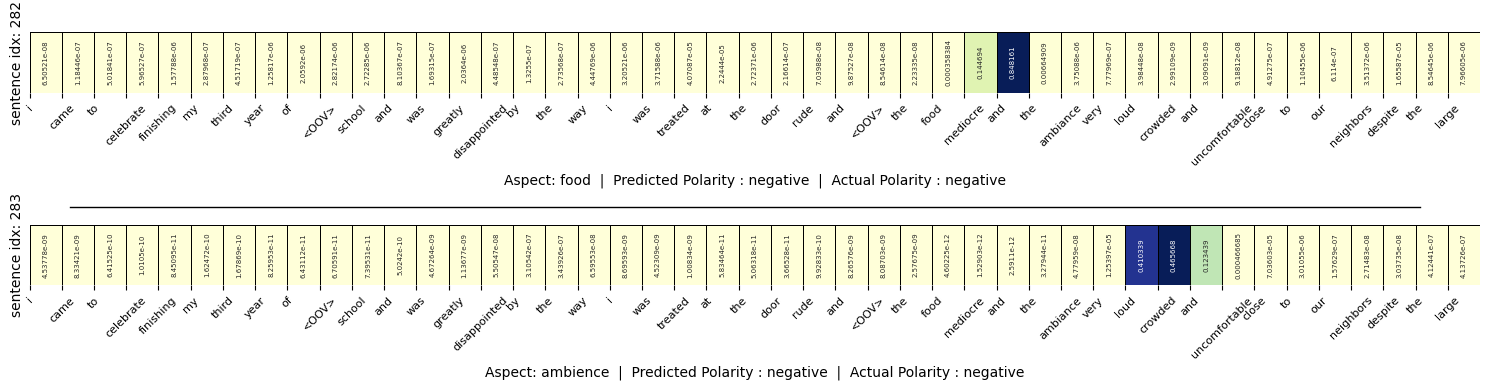

In [389]:
fig, axs = plt.subplots(2, 1, figsize=(15, 4))
# first, second =  [103,104]
#first, second =  [20,21]
first, second =  [282,283]
data = attention_weight_2.view(-1, attention_weight_2.shape[1])[first].cpu().detach().numpy()
# Reshape data into a 2D array with one row and the same number of columns as the length of the list
data_array = np.array(data).reshape(1, -1)
sns.heatmap(data_array, annot=True, annot_kws={"size": 5,'rotation': 90}, cmap="YlGnBu", fmt='g', cbar=False, linewidths=0.5, linecolor='black', ax=axs[0])
aspect_string = review_test_aspect[first][0]
predict_string = predicted_pol_[first]
test_polarity_string = test_polarity[first]
axs[0].set_title(' ')
axs[0].set_xlabel(f'Aspect: {aspect_string}  |  Predicted Polarity : {predict_string}  |  Actual Polarity : {test_polarity_string}')
axs[0].set_ylabel(f'sentence idx: {first}')
axs[0].set_xticks(np.arange(len(data)))
axs[0].set_xticklabels(labels=review_test_sent[first], fontsize=8, rotation=45)
axs[0].set_yticks([])
data_2 = attention_weight_2.view(-1, attention_weight_2.shape[1])[second].cpu().detach().numpy()
data_array_2 = np.array(data_2).reshape(1, -1)
sns.heatmap(data_array_2, annot=True, annot_kws={"size": 5,'rotation': 90}, cmap="YlGnBu", fmt='g', cbar=False, linewidths=0.5, linecolor='black', ax=axs[1])
aspect_string_2 = review_test_aspect[second][0]
predict_string_2 = predicted_pol_[second]
test_polarity_string_2 = test_polarity[second]
axs[1].set_title(' ')
axs[1].set_xlabel(f'Aspect: {aspect_string_2}  |  Predicted Polarity : {predict_string_2}  |  Actual Polarity : {test_polarity_string_2}')
axs[1].set_ylabel(f'sentence idx: {second}')
axs[1].set_xticks(np.arange(len(data)))
axs[1].set_xticklabels(labels=review_test_sent[second], fontsize=8, rotation=45)
axs[1].set_yticks([])
line = plt.Line2D((.05,.95),(.47,.47), color="k", linewidth=1)
fig.add_artist(line)
plt.tight_layout()
#plt.savefig("attention_weights_Hidden_dim_512.png")
plt.show()

In [481]:
from google.colab import files
files.download('attention_weights_Hidden_dim_512.png')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# 5.Reference

Some codes are adapted from the code provided in lab sheet.